# Import dependencies

In [96]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# base
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    RandomizedSearchCV,
    GridSearchCV,
)

# preprocessing and pipeline (workflow)
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# metrics
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    mean_squared_error,
    precision_score, 
    recall_score,
    f1_score,
)

# models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier


# Import cleaned data

In [2]:
df = pd.read_csv("../data/summer_men_100m_swimming_freestyle.csv")

In [3]:
df.head()

,Unnamed: 0,Name,Age,Height,Weight,NOC,Year,City,Medal,Times_Participated,Participation_Number
0,209,Oszkr Abay-Nemes,22.0,185.308036,79.379836,HUN,1936,Berlin,no medal,1,1
1,244,Mohammed Abbas Sabih,26.0,170.000000,70.000000,IRQ,2004,Athina,no medal,1,1
2,348,Dorri Abdel Kader Said,21.0,185.308036,79.379836,EGY,1948,London,no medal,3,1
3,351,Dorri Abdel Kader Said,25.0,185.308036,79.379836,EGY,1952,Helsinki,no medal,3,2
4,551,Roosevelt M. Abdulgafur,24.0,181.000000,73.000000,PHI,1968,Mexico City,no medal,1,1


In [4]:
df = df.drop(columns=["Unnamed: 0"])

In [6]:
print(df.shape)
df.head()

(1236, 10)


,Name,Age,Height,Weight,NOC,Year,City,Medal,Times_Participated,Participation_Number
0,Oszkr Abay-Nemes,22.0,185.308036,79.379836,HUN,1936,Berlin,no medal,1,1
1,Mohammed Abbas Sabih,26.0,170.000000,70.000000,IRQ,2004,Athina,no medal,1,1
2,Dorri Abdel Kader Said,21.0,185.308036,79.379836,EGY,1948,London,no medal,3,1
3,Dorri Abdel Kader Said,25.0,185.308036,79.379836,EGY,1952,Helsinki,no medal,3,2
4,Roosevelt M. Abdulgafur,24.0,181.000000,73.000000,PHI,1968,Mexico City,no medal,1,1


In [7]:
df.isna().sum()

Name                    0
Age                     0
Height                  0
Weight                  0
NOC                     0
Year                    0
City                    0
Medal                   0
Times_Participated      0
Participation_Number    0
dtype: int64

## Preprocessing

### Split data into train and test

In [ ]:
X = df.drop(columns=["Medal"])      # 
y = df["Medal"]

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=55, stratify=y)      
X_train.shape, X_test.shape

((988, 9), (248, 9))

In [13]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 988 entries, 947 to 356
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Name                  988 non-null    object 
 1   Age                   988 non-null    float64
 2   Height                988 non-null    float64
 3   Weight                988 non-null    float64
 4   NOC                   988 non-null    object 
 5   Year                  988 non-null    int64  
 6   City                  988 non-null    object 
 7   Times_Participated    988 non-null    int64  
 8   Participation_Number  988 non-null    int64  
dtypes: float64(3), int64(3), object(3)
memory usage: 77.2+ KB


### Separate categorical and numerical features

In [14]:
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
numeric_features = X_train.select_dtypes(include=['int', 'float']).columns.tolist()

categorical_features, numeric_features

(['Name', 'NOC', 'City'],
 ['Age',
  'Height',
  'Weight',
  'Year',
  'Times_Participated',
  'Participation_Number'])

### Define transformers pipelines

#### Standard transformer

In [15]:
categorical_transformer = Pipeline(steps=[("onehot", OneHotEncoder(sparse_output=False, handle_unknown="ignore").set_output(transform="pandas"))])
categorical_transformer

,steps,"[('onehot', ...)]"
,transform_input,None
,memory,None
,verbose,False
,categories,'auto'
,drop,None
,sparse_output,False
,dtype,<class 'numpy.float64'>
,handle_unknown,'ignore'
,min_frequency,None
,max_categories,None


In [16]:
numeric_transformer = Pipeline(steps=[("scaler", StandardScaler().set_output(transform="pandas"))])
numeric_transformer

,steps,"[('scaler', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True


In [17]:
preprocessor = ColumnTransformer(transformers=[("num", numeric_transformer, numeric_features),
                                               ("cat", categorical_transformer, categorical_features)
                                               ]).set_output(transform="pandas")
preprocessor

,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,copy,True
,with_mean,True
,with_std,True


#### Transformer for decision trees 
(since they don't require scaling)

In [53]:
categorical_transformer_tree = Pipeline(steps=[("onehot", OneHotEncoder(sparse_output=False, handle_unknown="ignore").set_output(transform="pandas"))])

# numeric_transformer_tree = Pipeline(steps=[])       # do-nothing transformer (an identity transformer)

preprocessor_tree = ColumnTransformer(transformers=[("num", "passthrough", numeric_features),
                                                    ("cat", categorical_transformer_tree, categorical_features)
                                                    ]).set_output(transform="pandas")
preprocessor_tree

,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,categories,'auto'
,drop,None
,sparse_output,False


# Models

### Create a dataframe to keep scores

In [18]:
scores_df = pd.DataFrame(columns=[
    "model_name",
    "F1",
    "Precision",
    "Recall",
])

scores_df

,model_name,F1,Precision,Recall


### Train and evaluate different models

#### Logistic regression

##### Initialize model and build pipeline

In [19]:
lr_model = LogisticRegression(random_state=42, solver='liblinear')
lr_model

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'liblinear'
,max_iter,100
,multi_class,'deprecated'


In [20]:
pipeline_lr = Pipeline(steps=[
                              ("pre_process", preprocessor),
                              ("model", lr_model)
                              ])
pipeline_lr

,steps,"[('pre_process', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


##### Train and evaluate model

In [21]:
pipeline_lr.fit(X_train, y_train)
y_pred = pipeline_lr.predict(X_test)

class_labels = pipeline_lr.named_steps['model'].classes_

print(classification_report(y_test, y_pred))

pd.DataFrame(confusion_matrix(y_test, y_pred),
             columns=class_labels, index=class_labels)

              precision    recall  f1-score   support

      Bronze       0.00      0.00      0.00         5
        Gold       0.00      0.00      0.00         5
      Silver       0.00      0.00      0.00         5
    no medal       0.94      1.00      0.97       233

    accuracy                           0.94       248
   macro avg       0.23      0.25      0.24       248
weighted avg       0.88      0.94      0.91       248



c:\Users\Catalina\.conda\envs\MLG\lib\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
c:\Users\Catalina\.conda\envs\MLG\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Catalina\.conda\envs\MLG\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

,Bronze,Gold,Silver,no medal
Bronze,0,0,0,5
Gold,0,0,0,5
Silver,0,0,0,5
no medal,0,0,0,233


##### Save scores

In [22]:
# add the scores to the dataframe

precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

new_row = {
    "model_name": "Logistic Regression",
    "F1": f1,
    "Precision": precision,
    "Recall": recall,
}

scores_df = pd.concat([scores_df, pd.DataFrame([new_row])], ignore_index=True)
scores_df

c:\Users\Catalina\.conda\envs\MLG\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\Catalina\AppData\Local\Temp\ipykernel_19212\116479860.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  scores_df = pd.concat([scores_df, pd.DataFrame([new_row])], ignore_index=True)


,model_name,F1,Precision,Recall
0,Logistic Regression,0.910217,0.882691,0.939516


#### KNN classifier

##### Initialize model and build pipeline

In [23]:
knn = KNeighborsClassifier()
knn

,n_neighbors,5
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


In [24]:
pipeline_knn = Pipeline([("pre_process", preprocessor),
                         ("model", knn)])
pipeline_knn

,steps,"[('pre_process', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


##### Train and evaluate model

In [25]:
pipeline_knn.fit(X_train, y_train)
y_pred = pipeline_knn.predict(X_test)

class_labels = pipeline_knn.named_steps['model'].classes_

print(classification_report(y_test, y_pred))

pd.DataFrame(confusion_matrix(y_test, y_pred),
             columns=class_labels, index=class_labels)

              precision    recall  f1-score   support

      Bronze       0.00      0.00      0.00         5
        Gold       0.00      0.00      0.00         5
      Silver       0.00      0.00      0.00         5
    no medal       0.94      1.00      0.97       233

    accuracy                           0.94       248
   macro avg       0.24      0.25      0.24       248
weighted avg       0.89      0.94      0.91       248



c:\Users\Catalina\.conda\envs\MLG\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Catalina\.conda\envs\MLG\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Catalina\.conda\envs\MLG\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


,Bronze,Gold,Silver,no medal
Bronze,0,1,0,4
Gold,0,0,0,5
Silver,0,0,0,5
no medal,0,0,0,233


##### Save scores

In [26]:
# add the scores to the dataframe

precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

new_row = {
    "model_name": "KNN Classifier",
    "F1": f1,
    "Precision": precision,
    "Recall": recall,
}

scores_df = pd.concat([scores_df, pd.DataFrame([new_row])], ignore_index=True)
scores_df

c:\Users\Catalina\.conda\envs\MLG\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


,model_name,F1,Precision,Recall
0,Logistic Regression,0.910217,0.882691,0.939516
1,KNN Classifier,0.912114,0.886264,0.939516


#### Naive Bayes

##### Initialize model and build pipeline

In [27]:
nb = BernoulliNB()
nb

,alpha,1.0
,force_alpha,True
,binarize,0.0
,fit_prior,True
,class_prior,None


In [28]:
pipeline_nb = Pipeline([("pre_process", preprocessor),
                        ("model", nb)])
pipeline_nb

,steps,"[('pre_process', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


##### Train and evaluate model

In [29]:
pipeline_nb.fit(X_train, y_train)
y_pred = pipeline_nb.predict(X_test)

class_labels = pipeline_nb.named_steps['model'].classes_

print(classification_report(y_test, y_pred))

pd.DataFrame(confusion_matrix(y_test, y_pred),
             columns=class_labels, index=class_labels)

              precision    recall  f1-score   support

      Bronze       0.00      0.00      0.00         5
        Gold       0.00      0.00      0.00         5
      Silver       0.00      0.00      0.00         5
    no medal       0.94      1.00      0.97       233

    accuracy                           0.94       248
   macro avg       0.23      0.25      0.24       248
weighted avg       0.88      0.94      0.91       248



c:\Users\Catalina\.conda\envs\MLG\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Catalina\.conda\envs\MLG\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Catalina\.conda\envs\MLG\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


,Bronze,Gold,Silver,no medal
Bronze,0,0,0,5
Gold,0,0,0,5
Silver,0,0,0,5
no medal,0,0,0,233


##### Save scores

In [30]:
# add the scores to the dataframe

precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

new_row = {
    "model_name": "Naive Bayes Classifier",
    "F1": f1,
    "Precision": precision,
    "Recall": recall,
}

scores_df = pd.concat([scores_df, pd.DataFrame([new_row])], ignore_index=True)
scores_df

c:\Users\Catalina\.conda\envs\MLG\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


,model_name,F1,Precision,Recall
0,Logistic Regression,0.910217,0.882691,0.939516
1,KNN Classifier,0.912114,0.886264,0.939516
2,Naive Bayes Classifier,0.910217,0.882691,0.939516


#### SVM classifier

##### Linear Support vector classification

###### Initialize model and build pipeline

In [31]:
svm = LinearSVC()
svm

,penalty,'l2'
,loss,'squared_hinge'
,dual,'auto'
,tol,0.0001
,C,1.0
,multi_class,'ovr'
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,verbose,0
,random_state,None


In [33]:
pipeline_svm = Pipeline([("pre_process", preprocessor),
                         ("model", svm)])
pipeline_svm

,steps,"[('pre_process', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


###### Train and evaluate model

In [34]:
pipeline_svm.fit(X_train, y_train)
y_pred = pipeline_svm.predict(X_test)

class_labels = pipeline_svm.named_steps['model'].classes_

print(classification_report(y_test, y_pred))

pd.DataFrame(confusion_matrix(y_test, y_pred),
             columns=class_labels, index=class_labels)

              precision    recall  f1-score   support

      Bronze       0.00      0.00      0.00         5
        Gold       0.00      0.00      0.00         5
      Silver       0.00      0.00      0.00         5
    no medal       0.95      0.99      0.97       233

    accuracy                           0.93       248
   macro avg       0.24      0.25      0.24       248
weighted avg       0.89      0.93      0.91       248



c:\Users\Catalina\.conda\envs\MLG\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


,Bronze,Gold,Silver,no medal
Bronze,0,1,1,3
Gold,0,0,0,5
Silver,0,1,0,4
no medal,1,2,0,230


###### Save scores

In [35]:
# add the scores to the dataframe

precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

new_row = {
    "model_name": "SVM Linear Classifier",
    "F1": f1,
    "Precision": precision,
    "Recall": recall,
}

scores_df = pd.concat([scores_df, pd.DataFrame([new_row])], ignore_index=True)
scores_df

,model_name,F1,Precision,Recall
0,Logistic Regression,0.910217,0.882691,0.939516
1,KNN Classifier,0.912114,0.886264,0.939516
2,Naive Bayes Classifier,0.910217,0.882691,0.939516
3,SVM Linear Classifier,0.909847,0.892929,0.927419


##### Support vector classification with Radial basis function

###### Initialize model and build pipeline

In [36]:
svm_rbf = SVC(kernel="rbf", gamma="scale")
svm_rbf

,C,1.0
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


In [37]:
pipeline_svm_rbf = Pipeline([("pre_process", preprocessor),
                             ("model", svm_rbf)])
pipeline_svm_rbf

,steps,"[('pre_process', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


###### Train and evaluate model

In [38]:
pipeline_svm_rbf.fit(X_train, y_train)
y_pred = pipeline_svm_rbf.predict(X_test)

class_labels = pipeline_svm_rbf.named_steps['model'].classes_

print(classification_report(y_test, y_pred))

pd.DataFrame(confusion_matrix(y_test, y_pred),
             columns=class_labels, index=class_labels)

              precision    recall  f1-score   support

      Bronze       0.00      0.00      0.00         5
        Gold       0.00      0.00      0.00         5
      Silver       0.00      0.00      0.00         5
    no medal       0.94      1.00      0.97       233

    accuracy                           0.94       248
   macro avg       0.23      0.25      0.24       248
weighted avg       0.88      0.94      0.91       248



c:\Users\Catalina\.conda\envs\MLG\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Catalina\.conda\envs\MLG\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Catalina\.conda\envs\MLG\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


,Bronze,Gold,Silver,no medal
Bronze,0,0,0,5
Gold,0,0,0,5
Silver,0,0,0,5
no medal,0,0,0,233


###### Save scores

In [ ]:
# add the scores to the dataframe

precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

new_row = {
    "model_name": "SVM Radial Classifier",
    "F1": f1,
    "Precision": precision,
    "Recall": recall,
}

scores_df = pd.concat([scores_df, pd.DataFrame([new_row])], ignore_index=True)
scores_df

c:\Users\Catalina\.conda\envs\MLG\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


,model_name,F1,Precision,Recall
0,Logistic Regression,0.910217,0.882691,0.939516
1,KNN Classifier,0.912114,0.886264,0.939516
2,Naive Bayes Classifier,0.910217,0.882691,0.939516
3,SVM Linear Classifier,0.909847,0.892929,0.927419
4,SVM Linear Classifier,0.910217,0.882691,0.939516


#### Decision tree

##### Initialize model and build pipeline

In [54]:
dtree = DecisionTreeClassifier(random_state=42)
dtree

,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [55]:
pipeline_dtree = Pipeline([("pre_process", preprocessor_tree),
                           ("model", dtree)])
pipeline_dtree

,steps,"[('pre_process', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


##### Train and evaluate model

In [56]:
pipeline_dtree.fit(X_train, y_train)
y_pred = pipeline_dtree.predict(X_test)

class_labels = pipeline_dtree.named_steps['model'].classes_

print(classification_report(y_test, y_pred))

pd.DataFrame(confusion_matrix(y_test, y_pred),
             columns=class_labels, index=class_labels)

              precision    recall  f1-score   support

      Bronze       0.00      0.00      0.00         5
        Gold       0.00      0.00      0.00         5
      Silver       0.00      0.00      0.00         5
    no medal       0.95      0.99      0.97       233

    accuracy                           0.93       248
   macro avg       0.24      0.25      0.24       248
weighted avg       0.89      0.93      0.91       248



c:\Users\Catalina\.conda\envs\MLG\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Catalina\.conda\envs\MLG\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Catalina\.conda\envs\MLG\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


,Bronze,Gold,Silver,no medal
Bronze,0,2,0,3
Gold,0,0,0,5
Silver,0,0,0,5
no medal,1,2,0,230


##### Save scores

In [ ]:
# add the scores to the dataframe

precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

new_row = {
    "model_name": "Decision Tree",
    "F1": f1,
    "Precision": precision,
    "Recall": recall,
}

scores_df = pd.concat([scores_df, pd.DataFrame([new_row])], ignore_index=True)
scores_df

c:\Users\Catalina\.conda\envs\MLG\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


,model_name,F1,Precision,Recall
0,Logistic Regression,0.910217,0.882691,0.939516
1,KNN Classifier,0.912114,0.886264,0.939516
2,Naive Bayes Classifier,0.910217,0.882691,0.939516
3,SVM Linear Classifier,0.909847,0.892929,0.927419
4,SVM Linear Classifier,0.910217,0.882691,0.939516
5,Decision tree Classifier,0.907936,0.889254,0.927419


#### Random forest

##### Initialize model and build pipeline

In [58]:
rf = RandomForestClassifier(random_state=42)
rf

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [59]:
pipeline_rf = Pipeline([("pre_process", preprocessor_tree),
                         ("model", rf)])
pipeline_rf

,steps,"[('pre_process', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


##### Train and evaluate model

In [60]:
pipeline_rf.fit(X_train, y_train)
y_pred = pipeline_rf.predict(X_test)

class_labels = pipeline_rf.named_steps['model'].classes_

print(classification_report(y_test, y_pred))

pd.DataFrame(confusion_matrix(y_test, y_pred),
             columns=class_labels, index=class_labels)

              precision    recall  f1-score   support

      Bronze       0.00      0.00      0.00         5
        Gold       0.00      0.00      0.00         5
      Silver       0.00      0.00      0.00         5
    no medal       0.94      1.00      0.97       233

    accuracy                           0.94       248
   macro avg       0.23      0.25      0.24       248
weighted avg       0.88      0.94      0.91       248



c:\Users\Catalina\.conda\envs\MLG\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Catalina\.conda\envs\MLG\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Catalina\.conda\envs\MLG\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


,Bronze,Gold,Silver,no medal
Bronze,0,0,0,5
Gold,0,0,0,5
Silver,0,0,0,5
no medal,0,0,0,233


##### Save scores

In [61]:
# add the scores to the dataframe

precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

new_row = {
    "model_name": "Random Forest",
    "F1": f1,
    "Precision": precision,
    "Recall": recall,
}

scores_df = pd.concat([scores_df, pd.DataFrame([new_row])], ignore_index=True)
scores_df

c:\Users\Catalina\.conda\envs\MLG\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


,model_name,F1,Precision,Recall
0,Logistic Regression,0.910217,0.882691,0.939516
1,KNN Classifier,0.912114,0.886264,0.939516
2,Naive Bayes Classifier,0.910217,0.882691,0.939516
3,SVM Linear Classifier,0.909847,0.892929,0.927419
4,SVM Linear Classifier,0.910217,0.882691,0.939516
5,Decision tree Classifier,0.907936,0.889254,0.927419
6,Random Forest,0.910217,0.882691,0.939516


#### AdaBoost

You do not need to scale numerical data for AdaBoostClassifier, especially when using DecisionTreeClassifier as the base estimator (which is the default)

##### Initialize model and build pipeline

In [64]:
ada_boost = AdaBoostClassifier(random_state=42)
ada_boost

,estimator,None
,n_estimators,50
,learning_rate,1.0
,algorithm,'deprecated'
,random_state,42


In [65]:
pipeline_ada_boost = Pipeline([("pre_process", preprocessor_tree),
                               ("model", ada_boost)])
pipeline_ada_boost

,steps,"[('pre_process', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


##### Train and evaluate model

In [66]:
pipeline_ada_boost.fit(X_train, y_train)
y_pred = pipeline_ada_boost.predict(X_test)

class_labels = pipeline_ada_boost.named_steps['model'].classes_

print(classification_report(y_test, y_pred))

pd.DataFrame(confusion_matrix(y_test, y_pred),
             columns=class_labels, index=class_labels)

              precision    recall  f1-score   support

      Bronze       0.00      0.00      0.00         5
        Gold       0.00      0.00      0.00         5
      Silver       0.00      0.00      0.00         5
    no medal       0.94      1.00      0.97       233

    accuracy                           0.94       248
   macro avg       0.23      0.25      0.24       248
weighted avg       0.88      0.94      0.91       248



c:\Users\Catalina\.conda\envs\MLG\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Catalina\.conda\envs\MLG\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Catalina\.conda\envs\MLG\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


,Bronze,Gold,Silver,no medal
Bronze,0,0,0,5
Gold,0,0,0,5
Silver,0,0,0,5
no medal,0,0,0,233


##### Save scores

In [67]:
# add the scores to the dataframe

precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

new_row = {
    "model_name": "AdaBoost",
    "F1": f1,
    "Precision": precision,
    "Recall": recall,
}

scores_df = pd.concat([scores_df, pd.DataFrame([new_row])], ignore_index=True)
scores_df

c:\Users\Catalina\.conda\envs\MLG\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


,model_name,F1,Precision,Recall
0,Logistic Regression,0.910217,0.882691,0.939516
1,KNN Classifier,0.912114,0.886264,0.939516
2,Naive Bayes Classifier,0.910217,0.882691,0.939516
3,SVM Linear Classifier,0.909847,0.892929,0.927419
4,SVM Linear Classifier,0.910217,0.882691,0.939516
5,Decision tree Classifier,0.907936,0.889254,0.927419
6,Random Forest,0.910217,0.882691,0.939516
7,AdaBoost,0.910217,0.882691,0.939516


#### Gradient Boosting

##### Initialize model and build pipeline

In [68]:
gbm = GradientBoostingClassifier(random_state=42)
gbm

,loss,'log_loss'
,learning_rate,0.1
,n_estimators,100
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,3
,min_impurity_decrease,0.0
,init,None


In [69]:
pipeline_gbm = Pipeline([("pre_process", preprocessor_tree),
                         ("model", gbm)])
pipeline_gbm

,steps,"[('pre_process', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


##### Train and evaluate model

In [70]:
pipeline_gbm.fit(X_train, y_train)
y_pred = pipeline_gbm.predict(X_test)

class_labels = pipeline_gbm.named_steps['model'].classes_

print(classification_report(y_test, y_pred))

pd.DataFrame(confusion_matrix(y_test, y_pred),
             columns=class_labels, index=class_labels)

              precision    recall  f1-score   support

      Bronze       0.00      0.00      0.00         5
        Gold       0.00      0.00      0.00         5
      Silver       0.00      0.00      0.00         5
    no medal       0.95      0.98      0.96       233

    accuracy                           0.92       248
   macro avg       0.24      0.24      0.24       248
weighted avg       0.89      0.92      0.90       248



,Bronze,Gold,Silver,no medal
Bronze,0,1,1,3
Gold,0,0,0,5
Silver,0,0,0,5
no medal,2,2,1,228


##### Save scores

In [71]:
# add the scores to the dataframe

precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

new_row = {
    "model_name": "Gradient Boosting",
    "F1": f1,
    "Precision": precision,
    "Recall": recall,
}

scores_df = pd.concat([scores_df, pd.DataFrame([new_row])], ignore_index=True)
scores_df

,model_name,F1,Precision,Recall
0,Logistic Regression,0.910217,0.882691,0.939516
1,KNN Classifier,0.912114,0.886264,0.939516
2,Naive Bayes Classifier,0.910217,0.882691,0.939516
3,SVM Linear Classifier,0.909847,0.892929,0.927419
4,SVM Linear Classifier,0.910217,0.882691,0.939516
5,Decision tree Classifier,0.907936,0.889254,0.927419
6,Random Forest,0.910217,0.882691,0.939516
7,AdaBoost,0.910217,0.882691,0.939516
8,Gradient Boosting,0.903838,0.888837,0.919355


#### XGBoost

##### Initialize model and build pipeline

In [73]:
xgb = XGBClassifier(random_state=42)
xgb

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [74]:
pipeline_xgb = Pipeline([("pre_process", preprocessor_tree),
                         ("model", xgb)])
pipeline_xgb

,steps,"[('pre_process', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


XGBoost doesn't work with string y labels &rarr; remember to label encode before fitting

In [75]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_le = le.fit_transform(y_train)
y_test_le = le.transform(y_test)

##### Train and evaluate model

In [76]:
pipeline_xgb.fit(X_train, y_train_le)
y_pred_le = pipeline_xgb.predict(X_test)

# reverse transform predicted 0s and 1s into string labels
y_pred = le.inverse_transform(y_pred_le)

In [77]:
class_labels = le.classes_

print(classification_report(y_test, y_pred))

pd.DataFrame(confusion_matrix(y_test, y_pred),
             columns=class_labels, index=class_labels)

              precision    recall  f1-score   support

      Bronze       0.00      0.00      0.00         5
        Gold       0.00      0.00      0.00         5
      Silver       0.00      0.00      0.00         5
    no medal       0.95      0.99      0.97       233

    accuracy                           0.93       248
   macro avg       0.24      0.25      0.24       248
weighted avg       0.89      0.93      0.91       248



c:\Users\Catalina\.conda\envs\MLG\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Catalina\.conda\envs\MLG\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Catalina\.conda\envs\MLG\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


,Bronze,Gold,Silver,no medal
Bronze,0,2,0,3
Gold,0,0,0,5
Silver,0,0,0,5
no medal,1,1,0,231


##### Save scores

In [78]:
# add the scores to the dataframe

precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

new_row = {
    "model_name": "XGBoost",
    "F1": f1,
    "Precision": precision,
    "Recall": recall,
}

scores_df = pd.concat([scores_df, pd.DataFrame([new_row])], ignore_index=True)
scores_df

c:\Users\Catalina\.conda\envs\MLG\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


,model_name,F1,Precision,Recall
0,Logistic Regression,0.910217,0.882691,0.939516
1,KNN Classifier,0.912114,0.886264,0.939516
2,Naive Bayes Classifier,0.910217,0.882691,0.939516
3,SVM Linear Classifier,0.909847,0.892929,0.927419
4,SVM Linear Classifier,0.910217,0.882691,0.939516
5,Decision tree Classifier,0.907936,0.889254,0.927419
6,Random Forest,0.910217,0.882691,0.939516
7,AdaBoost,0.910217,0.882691,0.939516
8,Gradient Boosting,0.903838,0.888837,0.919355
9,XGBoost,0.909972,0.889460,0.931452


### Compare model performance after one fit

In [80]:
scores_df

,model_name,F1,Precision,Recall
0,Logistic Regression,0.910217,0.882691,0.939516
1,KNN Classifier,0.912114,0.886264,0.939516
2,Naive Bayes Classifier,0.910217,0.882691,0.939516
3,SVM Linear Classifier,0.909847,0.892929,0.927419
4,SVM Linear Classifier,0.910217,0.882691,0.939516
5,Decision tree Classifier,0.907936,0.889254,0.927419
6,Random Forest,0.910217,0.882691,0.939516
7,AdaBoost,0.910217,0.882691,0.939516
8,Gradient Boosting,0.903838,0.888837,0.919355
9,XGBoost,0.909972,0.889460,0.931452


In [82]:
best_score = scores_df[scores_df["F1"] == scores_df["F1"].max()].reset_index(drop=True)
best_score

,model_name,F1,Precision,Recall
0,KNN Classifier,0.912114,0.886264,0.939516


In [110]:
print(f"{best_score['model_name'][0]} got best score with an accuracy of {best_score['F1'][0]:.3f}")

KNN Classifier got best score with an accuracy of 0.912


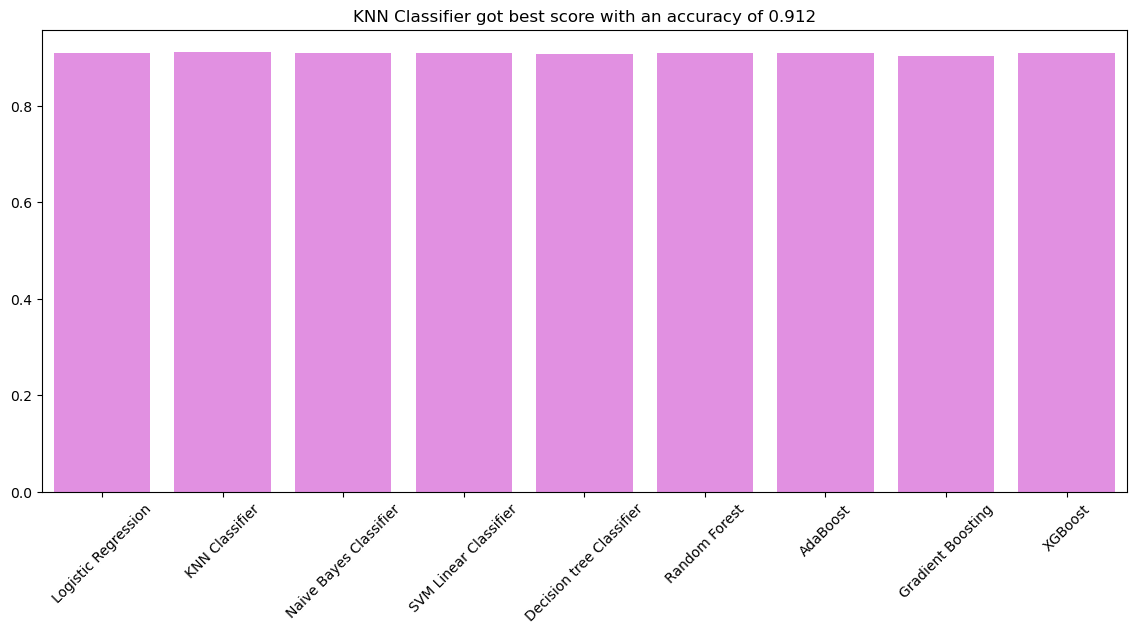

In [111]:
plt.figure(figsize=(14, 6))
sns.barplot(x=list(scores_df["model_name"]),
            y=list(scores_df["F1"]), color="violet")
plt.title(f"{best_score['model_name'][0]} got best score with an accuracy of {best_score['F1'][0]:.3f}")
plt.xticks(rotation=45)
plt.show()

### Compare model performance after cross validation

#### Calculate scores

In [105]:
scores_cv = {}
scores_cv['log_reg'] = cross_val_score(pipeline_lr, X_train, y_train, cv=5, scoring='f1_weighted')
scores_cv['knn'] = cross_val_score(pipeline_knn, X_train, y_train, cv=5, scoring='f1_weighted')
scores_cv['nb'] = cross_val_score(pipeline_nb, X_train, y_train, cv=5, scoring='f1_weighted')
scores_cv['svm'] = cross_val_score(pipeline_svm, X_train, y_train, cv=5, scoring='f1_weighted')
scores_cv['svm_rbf'] = cross_val_score(pipeline_svm_rbf, X_train, y_train, cv=5, scoring='f1_weighted')
scores_cv['dtree'] = cross_val_score(pipeline_dtree, X_train, y_train, cv=5, scoring='f1_weighted')
scores_cv['rf'] = cross_val_score(pipeline_rf, X_train, y_train, cv=5, scoring='f1_weighted')
scores_cv['ada_boost'] = cross_val_score(pipeline_ada_boost, X_train, y_train, cv=5, scoring='f1_weighted')
scores_cv['gbm'] = cross_val_score(pipeline_gbm, X_train, y_train, cv=5, scoring='f1_weighted')
scores_cv['xgb'] = cross_val_score(pipeline_xgb, X_train, y_train_le, cv=5, scoring='f1_weighted')

c:\Users\Catalina\.conda\envs\MLG\lib\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
c:\Users\Catalina\.conda\envs\MLG\lib\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
c:\Users\Catalina\.conda\envs\MLG\lib\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solv

In [106]:
scores_cv_df = pd.DataFrame({
    "model_name" : scores_cv.keys(),
    'F1': [round(np.mean(scores), 3) for scores in scores_cv.values()]
})

scores_cv_df

,model_name,F1
0,log_reg,0.907
1,knn,0.903
2,nb,0.907
3,svm,0.918
4,svm_rbf,0.907
5,dtree,0.919
6,rf,0.909
7,ada_boost,0.907
8,gbm,0.920
9,xgb,0.911


#### Choose best score

In [107]:
best_score_cv = scores_cv_df[scores_cv_df["F1"] == scores_cv_df["F1"].max()].reset_index(drop=True)
best_score_cv

,model_name,F1
0,gbm,0.92


In [ ]:
print(f"{best_score_cv['model_name'][0]} got best score with an accuracy of {best_score_cv['F1'][0]:.3f}")

Best score is gbm with an accuracy of 0.920


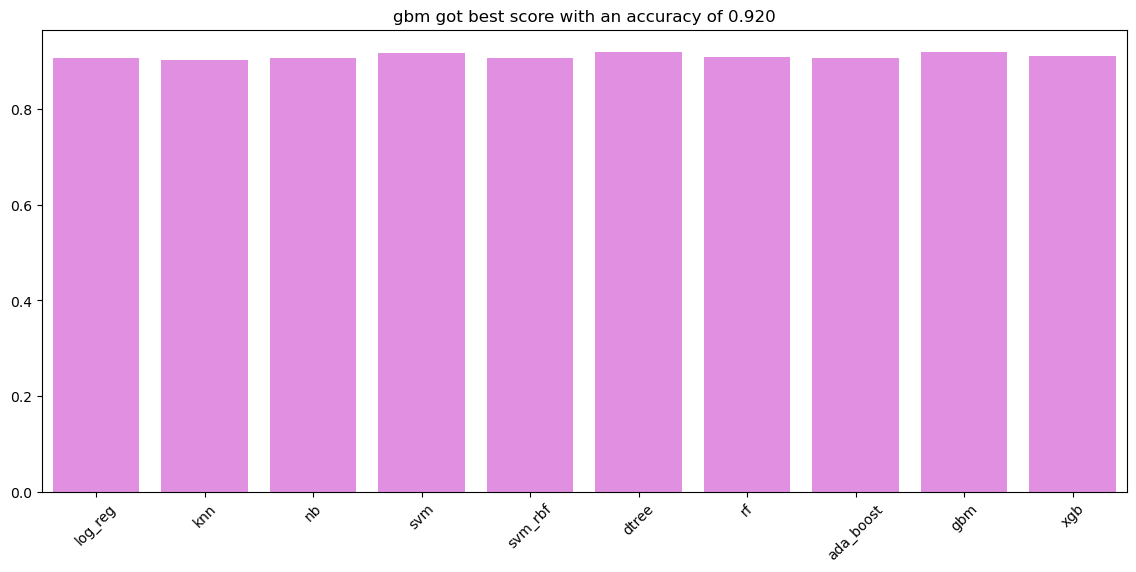

In [112]:
plt.figure(figsize=(14, 6))
sns.barplot(x=list(scores_cv_df["model_name"]),
            y=list(scores_cv_df["F1"]), color="violet")
plt.title(f"{best_score_cv['model_name'][0]} got best score with an accuracy of {best_score_cv['F1'][0]:.3f}")
plt.xticks(rotation=45)
plt.show()

# Hyperparameter tuning

 Approach
 1. Use Randomized Search to narrow down wide range of hyperparameters.
 2. Then use grid search to optimize in the close range of the result from RandomizedSearch

## Select best model (for hyperparameter tuning)

In [114]:
def assign_best_model(model_name):    
    if model_name == "log_reg":
        best_model = LogisticRegression(random_state=42, solver='liblinear')
    elif model_name == "knn":
        best_model = KNeighborsClassifier()
    elif model_name == "nb":
        best_model = BernoulliNB()
    elif model_name == "svm":
        best_model = LinearSVC()
    elif model_name == "svm_rbf":
        best_model = SVC(kernel="rbf", gamma="scale")
    elif model_name == "dtree":
        best_model = DecisionTreeClassifier(random_state=42)
    elif model_name == "rf":
        best_model = RandomForestClassifier(random_state=42)
    elif model_name == "ada_boost":
        best_model = AdaBoostClassifier(random_state=42)
    elif model_name == "gbm":
        best_model = GradientBoostingClassifier(random_state=42)
    elif model_name == "xgb":
        best_model = XGBClassifier(random_state=42)    
    
    return best_model

In [115]:
model = assign_best_model(best_score_cv['model_name'][0])
model

,loss,'log_loss'
,learning_rate,0.1
,n_estimators,100
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,3
,min_impurity_decrease,0.0
,init,None


## Randomized Search

In [116]:
ohe = OneHotEncoder(handle_unknown="ignore")  

In [117]:
model_pipeline = Pipeline([("one_hot_enc", ohe), ("clf", model)]) 
model_pipeline

,steps,"[('one_hot_enc', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,categories,'auto'
,drop,None
,sparse_output,True
,dtype,<class 'numpy.float64'>
,handle_unknown,'ignore'
,min_frequency,None
,max_categories,None


In [118]:
rand_params = [
    {"clf": [KNeighborsClassifier()], "clf__n_neighbors": [1, 3, 5, 7, 9]},
    {"clf": [BernoulliNB()]},
    {"clf": [LinearSVC(max_iter=2000)], "clf__C": [0.01, 0.1, 1, 5, 10, 100]},
    {
        "clf": [SVC()],
        "clf__C": [0.01, 0.1, 1, 5, 10, 100],
        "clf__kernel": ["rbf", "poly"],
        "clf__gamma": ["scale"],
        "clf__decision_function_shape": ["ovo"],
    },
    {
        "clf": [RandomForestClassifier()],
        "clf__n_estimators": list(range(50, 950, 100)),
        "clf__max_depth": [None, 1, 2, 5, 7, 10, 15, 25, 40],
    },
]

In [119]:
rand_cv = RandomizedSearchCV(
    model_pipeline,
    rand_params,
    cv=5,
    n_iter=25,
    scoring=["f1", "accuracy"],
    refit="f1",
    n_jobs=-1,
)

In [120]:
rand_cv.fit(X_train, y_train) 

c:\Users\Catalina\.conda\envs\MLG\lib\site-packages\sklearn\model_selection\_search.py:1135: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan]
  warnings.warn(


,estimator,Pipeline(step...m_state=42))])
,param_distributions,"[{'clf': [KNeighborsClassifier()], 'clf__n_neighbors': [1, 3, ...]}, {'clf': [BernoulliNB()]}, ...]"
,n_iter,25
,scoring,"['f1', 'accuracy']"
,n_jobs,-1
,refit,'f1'
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,None
,error_score,nan


In [121]:
print(f"Best F1-score: {rand_cv.best_score_:.3f}\n")
print("-------------------------------------------------------------")
print(f"Best parameter set: {rand_cv.best_params_}\n")
print("-------------------------------------------------------------")
print(f"Scores:\n {classification_report(y_train, rand_cv.predict(X_train))}")

Best F1-score: nan

-------------------------------------------------------------
Best parameter set: {'clf__n_estimators': 250, 'clf__max_depth': 2, 'clf': RandomForestClassifier()}

-------------------------------------------------------------
Scores:
               precision    recall  f1-score   support

      Bronze       0.00      0.00      0.00        20
        Gold       0.00      0.00      0.00        20
      Silver       0.00      0.00      0.00        22
    no medal       0.94      1.00      0.97       926

    accuracy                           0.94       988
   macro avg       0.23      0.25      0.24       988
weighted avg       0.88      0.94      0.91       988



c:\Users\Catalina\.conda\envs\MLG\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Catalina\.conda\envs\MLG\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Catalina\.conda\envs\MLG\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


## Grid Search

# Stacking classifier